In [2]:
import os
import sys

# Use the current working directory instead of __file__
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.pinopi as pnp
import classifiers.classifier as classifier
import pickle

In [3]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
print(f"{q1}\n{q2}")

a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / 1.5
# if J is in units of rad/micros
J_to_a = 1 / a_to_J
J=q1.ef_amp*a_to_J
print(J)

Qubit(qubit_thr=[-10000, -600], RO_LO_pwr=16, ROIF=0.10268999999999995, ef_time=49, IQ_angle=110, RO_IF=None, ro_amp=0.15, RO_LO=6.6247, ef_ssm=-0.2568, ef_amp=1.48, ro_freq=6.72739, ge_time=82, ge_ssm=-0.1144, ge_amp=0.795, ro_dur=5000, qubit_id=q1)
Qubit(qubit_thr=[-10000, 1900], RO_LO_pwr=16, ROIF=0.030840000000000423, ef_time=None, IQ_angle=25, RO_IF=None, ro_amp=0.7, RO_LO=6.6247, ef_ssm=-0.2962, ef_amp=1, ro_freq=6.65554, ge_time=55, ge_ssm=-0.154, ge_amp=0.8, ro_dur=5000, qubit_id=q2)
31.629640321856424


In [3]:
general_vals_dict["wx_offs"] = [0.7, 0, -0.08, 0]

In [4]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)
num_steps = 3
reps = 10000
swap_freq= -.0194
swap_time=0.5*7/abs(swap_freq)#169#0.5*4/abs(swap_freq)
phase = 0
swap_amp = 1.36

In [5]:
def pi_nopi(
    comp="z",
    copief=0,
    pi_time=10,
    pi_amp=1,
    pi_phase=0,
    q1=q1,
    q2=q2,
    general_vals_dict=general_vals_dict,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    # sweeppiamp.pi_ge_amp(
    #     q1, q2, general_vals_dict, num_steps, amp, pi_ge, swap_freq, swap_time
    # )
    if comp == "z":

        pnp.pi_nopi_z(
                q1,
                q2,
                general_vals_dict,
                copief=copief,
                num_steps=3,
                swap_freq=swap_freq,
                swap_time=swap_time,
                phase=phase,
                swap_amp=swap_amp,
                pi_time=pi_time,
                pi_amp=pi_amp,
                pi_phase=pi_phase
            )
        
    elif comp == "x":
        pnp.pi_nopi_x(
                q1,
                q2,
                general_vals_dict,
                copief=copief,
                num_steps=3,
                swap_freq=swap_freq,
                swap_time=swap_time,
                phase=phase,
                swap_amp=swap_amp,
                pi_time=pi_time,
                pi_amp=pi_amp,
                pi_phase=pi_phase
            )
    elif comp == "y":
        pnp.pi_nopi_y(
                q1,
                q2,
                general_vals_dict,
                copief=copief,
                num_steps=3,
                swap_freq=swap_freq,
                swap_time=swap_time,
                phase=phase,
                swap_amp=swap_amp,
                pi_time=pi_time,
                pi_amp=pi_amp,
                pi_phase=pi_phase
                
            )

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probablities = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)
    P_f=np.mean(probablities['P_f']/(probablities['P_f']+probablities['P_e']))
        

    return P_f

In [ ]:
# # q1.ge_amp=0.795
# # q1.ef_amp=1.48
# pi_time=24
# pi_amp=1.53
# pi_phase=45
# sweep_start=0
# sweep_end=180
# sweep_steps=11
# sweep_vals = np.linspace(sweep_start, sweep_end, sweep_steps)
# sweep_data_1 = np.zeros(sweep_steps)
# sweep_data_2 = np.zeros(sweep_steps)
# # Define folders for plus and minus data (adjust folder names as needed)
# plus_folder = os.path.join("phase_data", "plus")
# minus_folder = os.path.join("phase_data", "minus")
# os.makedirs(plus_folder, exist_ok=True)
# os.makedirs(minus_folder, exist_ok=True)

# # Initialize dictionaries for storing the loaded or computed data
# return_dict = {}   # for plus measurements
# return_vals = {}   # for minus measurements

# # Optionally, if you want to keep track of the data in lists/arrays:
# sweep_data_plus = {}
# sweep_data_minus = {}

# # Loop over sweep values (e.g., different pi_phase values)
# for i, sweep_val in enumerate(sweep_vals):
#     # Build filenames using the sweep value as part of the name
#     plus_filename = os.path.join(plus_folder, f"pi_phase={sweep_val:.5f}.pkl")
#     minus_filename = os.path.join(minus_folder, f"pi_phase={sweep_val:.5f}.pkl")
    
#     # If both files exist, load them and store in the dictionaries
#     if os.path.exists(plus_filename) and os.path.exists(minus_filename):
#         with open(plus_filename, "rb") as f:
#             plus_data = pickle.load(f)
#         with open(minus_filename, "rb") as f:
#             minus_data = pickle.load(f)
#         return_dict[sweep_val] = plus_data
#         return_vals[sweep_val] = minus_data
#         continue  # Skip to the next sweep value if files exist

#     # Otherwise, perform the measurement:
#     # Use the current sweep value as pi_phase
#     pi_phase = sweep_val

#     # Call pi_nopi for the two cases (the second argument distinguishes the plus/minus measurement)
#     P_f_minus_x = pi_nopi("x", 0, pi_time, pi_amp, pi_phase, q1, q2, general_vals_dict)
#     P_f_plus_x  = pi_nopi("x", 1, pi_time, pi_amp, pi_phase, q1, q2, general_vals_dict)
    
#     # Optionally store the results in arrays/dictionaries keyed by the index
#     sweep_data_minus[i] = P_f_minus_x
#     sweep_data_plus[i]  = P_f_plus_x

#     # Save the measurement results to their respective pickle files
#     with open(plus_filename, "wb") as f:
#         pickle.dump(P_f_plus_x, f)
#     with open(minus_filename, "wb") as f:
#         pickle.dump(P_f_minus_x, f)
    
#     # Populate the return dictionaries (using the sweep value as the key)
#     return_dict[sweep_val] = P_f_plus_x
#     return_vals[sweep_val] = P_f_minus_x

# # Optionally, return the dictionaries from a function or process further
# print("Measurement complete!")
# # For example, if this is inside a function:
# # return return_dict, return_vals
    
    


    
# # P_f_minus_z = pi_nopi("z",0,pi_time,pi_amp,pi_phase,q1,q2,general_vals_dict)
# # P_f_plus_z = pi_nopi("z",1,pi_time,pi_amp,pi_phase,q1,q2,general_vals_dict)
# # P_f_minus_x = pi_nopi("x",0,pi_time,pi_amp,pi_phase,q1,q2,general_vals_dict)
# # P_f_plus_x = pi_nopi("x",1,pi_time,pi_amp,pi_phase,q1,q2,general_vals_dict)
# # P_f_minus_y = pi_nopi("y",0,pi_time,pi_amp,pi_phase,q1,q2,general_vals_dict)
# # P_f_plus_y = pi_nopi("y",1,pi_time,pi_amp,pi_phase,q1,q2,general_vals_dict)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 3
Records per pattern: 10000
Buffers per acquistion: 10
DAQ samples per pattern: 8192
0, No error
Capturing 10 buffers. Press <enter> to abort
Capture completed in 3.741782 sec
Captured 10 buffers (2.672524 buffers per sec)
Captured 30720 records (8209.992556 records per sec)
Transferred 503316480 bytes (134512518.045231 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0,

In [32]:
pi_time=24
sweep_start_1=1.56
sweep_end_1=1.61
sweep_steps_1=6
sweep_start_2=0
sweep_end_2=360
sweep_steps_2=21
sweep_vals1 = np.linspace(sweep_start_1, sweep_end_1, sweep_steps_1)  # list of values for the first parameter (e.g., pi_phase1)
sweep_vals2 = np.linspace(sweep_start_2, sweep_end_2, sweep_steps_2)  # list of values for the second parameter (e.g., pi_phase2)
result_folder =  os.path.join("phase_data", "Prob")

# Ensure the result folder exists
os.makedirs(result_folder, exist_ok=True)

# Dictionary to store results keyed by a tuple (sweep_val1, sweep_val2)
results = {}

# Nested loops to sweep both parameters
for i, sweep_val1 in enumerate(sweep_vals1):
    pi_amp = sweep_val1
    for j, sweep_val2 in enumerate(sweep_vals2):
        # Build filename with both sweep values and updated measurement name "P_f_x"
        filename = os.path.join(
            result_folder,
            f"amp={sweep_val1:.5f}_pi_phase={sweep_val2:.5f}_P_f_x.pkl"
        )
        
        # If the file already exists, load the measurement result
        if os.path.exists(filename):
            with open(filename, "rb") as f:
                P_f_x = pickle.load(f)
            results[(sweep_val1, sweep_val2)] = P_f_x
            continue  # Skip to the next parameter combination
        pi_phase = sweep_val2
        # Perform the measurement 
        P_f_x = pi_nopi("x", 0, pi_time, pi_amp, pi_phase, q1, q2, general_vals_dict)
        
        
        
        # Save the measurement result to the file
        with open(filename, "wb") as f:
            pickle.dump(P_f_x, f)
        
        # Store the result in the dictionary, keyed by the sweep values
        results[(sweep_val1, sweep_val2)] = P_f_x


writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 3
Records per pattern: 10000
Buffers per acquistion: 10
DAQ samples per pattern: 8192
0, No error
Capturing 10 buffers. Press <enter> to abort
Capture completed in 3.762616 sec
Captured 10 buffers (2.657725 buffers per sec)
Captured 30720 records (8164.531477 records per sec)
Transferred 503316480 bytes (133767683.716500 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0,

(0.0, 360.0)

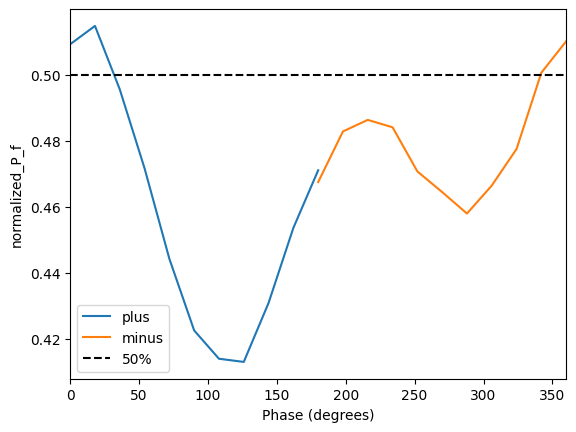

In [ ]:
# for i in range(sweep_steps):
#     sweep_data_1[i] = return_dict[sweep_vals[i]]
#     sweep_data_2[i] = return_vals[sweep_vals[i]]

# plt.plot(sweep_vals, sweep_data_1, label="plus")
# plt.plot(sweep_vals+180, sweep_data_2, label="minus")
# plt.axhline(0.5, color="k", linestyle="--", label="50%")
# plt.xlabel("Phase (degrees)")
# plt.ylabel("normalized_P_f")
# plt.legend()
# plt.xlim(sweep_start, sweep_end+180)

In [ ]:
# max_index = np.unravel_index(np.argmax(sweep_data),sweep_data.shape)
#     # min_index_P_ge = np.unravel_index(np.argmin(P_ge),P_ge.sh
# sweep_vals[max_index[0]]

1.48

In [ ]:
# # print('P_f_minus_z:',P_f_minus_z)
# # print('P_f_plus_z:',P_f_plus_z)
# print('P_f_minus_x:',P_f_minus_x)
# print('P_f_plus_x:',P_f_plus_x)
# print('P_f_minus_y:',P_f_minus_y)
# print('P_f_plus_y:',P_f_plus_y)

P_f_minus_x: 0.48978337995885113
P_f_plus_x: 0.49056655853404907
P_f_minus_y: 0.4783255366590125
P_f_plus_y: 0.4241527469802024


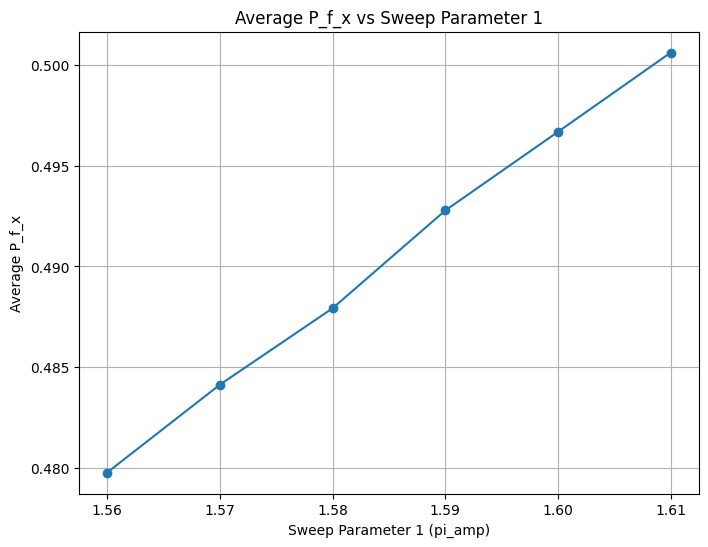

In [33]:
# Group results by sweep_val1
grouped_results = {}
for (sweep_val1, sweep_val2), P_f_x in results.items():
    # Initialize list for this sweep_val1 if needed
    if sweep_val1 not in grouped_results:
        grouped_results[sweep_val1] = []
    grouped_results[sweep_val1].append(P_f_x)

# Prepare lists for plotting: sort sweep_val1 keys to ensure proper order
sweep_val1_list = sorted(grouped_results.keys())
average_pf_x = [np.mean(grouped_results[s1]) for s1 in sweep_val1_list]

# Plot average P_f_x versus sweep_val1
plt.figure(figsize=(8, 6))
plt.plot(sweep_val1_list, average_pf_x, marker='o', linestyle='-')
plt.xlabel('Sweep Parameter 1 (pi_amp)')
plt.ylabel('Average P_f_x')
plt.title('Average P_f_x vs Sweep Parameter 1')
plt.grid(True)
plt.show()

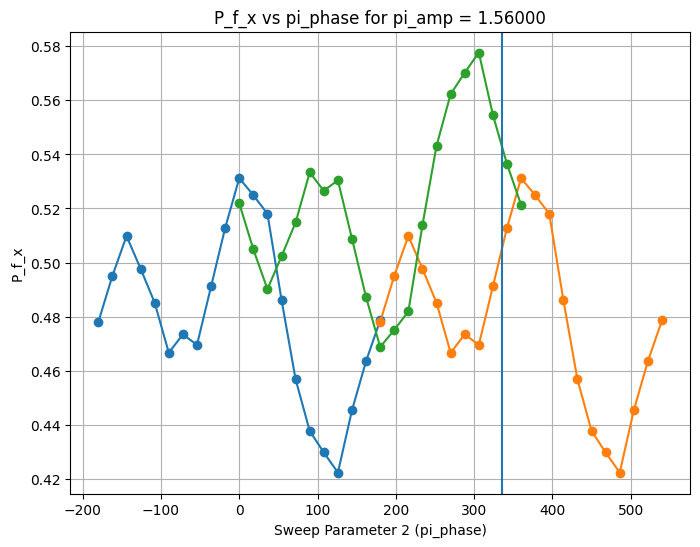

In [55]:
# Set the target value for sweep_vals1 (pi_amp) you want to extract
target_sweep_val1 = 1.56
tol = 1e-5  # tolerance for floating-point comparisons

# Extract the corresponding sweep_vals2 (pi_phase) and P_f_x measurements for target_sweep_val1
sweep_vals2_for_target = []
P_f_x_for_target = []

for (s1, s2), P_f in results.items():
    if abs(s1 - target_sweep_val1) < tol:
        sweep_vals2_for_target.append(s2)
        P_f_x_for_target.append(P_f)

# Sort the data by sweep_vals2 to ensure a proper plot
sweep_vals2_for_target, P_f_x_for_target = zip(*sorted(zip(sweep_vals2_for_target, P_f_x_for_target)))

# Plot P_f_x versus sweep_vals2 (pi_phase) for the fixed pi_amp = 1.55
plt.figure(figsize=(8,6))
plt.plot(np.array(sweep_vals2_for_target)-180, P_f_x_for_target, marker='o', linestyle='-')
plt.plot(np.array(sweep_vals2_for_target)+180, P_f_x_for_target, marker='o', linestyle='-')
plt.plot(np.array(sweep_vals2_for_target),1-np.array( P_f_x_for_target), marker='o', linestyle='-')
plt.xlabel('Sweep Parameter 2 (pi_phase)')
plt.ylabel('P_f_x')
plt.title(f'P_f_x vs pi_phase for pi_amp = {target_sweep_val1:.5f}')
plt.axvline(335)
plt.grid(True)
plt.show()

In [38]:
sweep_vals2_for_target-180

TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

In [36]:
sweep_vals2_for_target

(0.0,
 18.0,
 36.0,
 54.0,
 72.0,
 90.0,
 108.0,
 126.0,
 144.0,
 162.0,
 180.0,
 198.0,
 216.0,
 234.0,
 252.0,
 270.0,
 288.0,
 306.0,
 324.0,
 342.0,
 360.0)